In [37]:
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
from numpy import log as ln
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
from sympy import symbols, solve
import json
from time import process_time
import sys


# Overall Model Parameters

In [89]:
#Fixed parameters
sensitivity_steps = 1 #Number of parameter values scanned for sensitivity parameter specified below
simulations = 1
annual_decisions = 2 #Number of times an agent is evaluating strategy on average
households = 100
time = 10000
mu_farm = 163.4
farm_k = 0.808 #Shape factor for farming income distribution (Weibull)
alpha = 0.9 #Proportion of full farm income that is still earned by households engaging in migration
cost_farm = 170

mu_migrate = 594.8 #200
var_migrate = 998.2 ** 2 #190**2
cost_migrate = 500 #62.5 

beta = 0.1 #Proportion of income that is shared in collective
objective_drought = 0.2 #Presumed drought risk in 2021, to set income threshold for drought vs. non-drought year
p_drought = 0.5 #This can vary based on severity of climate risk that is to be modelled
p_cov = 0.2 #Pearson's correlation coefficient for farming (i.e. covariate risk)
rho_mig = 0.0 #Pearson's correlation coefficient for farming and migration income streams

discount_rate = 0.2
time_horizon = 10 #Number of cycles across which a household evaluates options

utility_function = 'Self-Interested'

risk_factor = 0.5
altruism_factor = 1.0 #Degree to which individuals account for other households' utility, should range from [0,1]
max_altruism = 2.0 #Scalar by which others' utilities are multiplied, before applying altruism factor. Can take on any non-zero number. 1 = household caring about the sum of other households equally to their own for altruism factor = 1. 

k = 1.0 #Probability of an agent following another agent
sel_strength = 5.0 #Strength of selection effect
mutation_rate= 0#1 / households



# Model Functions

## Calculating Variances of Drought and Non-Drought Income Distributions

In [39]:
#Calculate variance of truncated distributions (for drought vs. non-drought distributions)
def trunc_var(income_sample, mu):
    running_var = 0
    N = len(income_sample)
    for i in range(N):
        running_var += (income_sample[i] - mu) ** 2
    
    var = running_var / (N - 1)
    
    return var

#Define drought and non-drought portions of farming income distribution
def farm_drought(mu_farm, farm_k, p_drought, objective_drought):
    
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))
        
    income_distribution = scale * np.random.weibull(farm_k, size=1000000)
    sorted_income = list(np.sort(income_distribution))
    drought_threshold = int(objective_drought * len(sorted_income))
    
    nondrought_incomes = sorted_income[drought_threshold:len(sorted_income)]
    
    if p_drought == 0:
        drought_incomes = nondrought_incomes
    else:
        drought_incomes = sorted_income[0:drought_threshold]
    
    
    mu_farm_drought = np.average(drought_incomes)
    mu_farm_nd = np.average(nondrought_incomes)
    
    var_drought = trunc_var(drought_incomes, mu_farm)
    var_nd = trunc_var(nondrought_incomes, mu_farm)
    var_ins = trunc_var(nondrought_incomes, mu_farm_nd)
    
    return mu_farm_drought, mu_farm_nd, var_drought, var_nd, var_ins
    
#Calculate variance from Weibull distribution parameters
def wei_var(mu, k):
    scale = (mu / math.gamma(1 + 1 / k))
    variance = scale ** 2 * (math.gamma(1 + 2 / k) - (math.gamma(1 + 1 / k)) ** 2)
    return variance


## Calculating Incomes and NPV of Income

In [40]:
#Calculate NPV based on annual income, costs, and discount rate
def npv_calc(time_horizon, strategy, strategy_cost, farm_income, shared_income, remittances, migration_cost, discount_rate):
    income = np.zeros(time_horizon)
    costs = np.zeros(time_horizon)
    
    #Accounting for different costs/income in initial time step of migration
    if 'Migrate' in strategy:
        costs[0] = strategy_cost
        income[0] = farm_income + shared_income
        for i in range(1, time_horizon):
            income[i] = farm_income + remittances + shared_income
            costs[i] = strategy_cost - migration_cost #Becuase strategy_costs captures costs related to all strategy components
    else:
        for i in range(0, time_horizon):
            costs[i] = strategy_cost
            income[i] = farm_income + remittances + shared_income
        
    npv = 0
    for i in range(time_horizon):
        npv += (income[i] - costs[i]) / ((1 + discount_rate) ** i)
        
    return npv
        

# Calculate expected income from strategy options as a function of strategy distribution
def income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate):
        
    #Income generated by own household
    farm_income = {'Farm': p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd, 
                     'FarmMigrate': alpha * (p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd), 
                     'Farm+Share': p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd, 
                     'FarmMigrate+Share': alpha * (p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd), 
                     'Farm+Ins': mu_farm_nd, 
                     'FarmMigrate+Ins': mu_farm_nd * alpha, 
                     'Farm+Share+Ins': mu_farm_nd, 
                     'FarmMigrate+Share+Ins': mu_farm_nd * alpha}
    
    remittances = {'Farm': 0, 
                   'FarmMigrate': mu_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': mu_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': mu_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': mu_migrate}
    
    shared_pool = 0
    shared_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            shared_pool += beta * frequency_dist[item] * (farm_income[item] + remittances[item])
            shared_dist += frequency_dist[item]
    
    if shared_dist == 0:
        household_share = 0
    else:
        household_share = shared_pool / shared_dist
        
    shared_income_received = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': household_share, 
                   'FarmMigrate+Share': household_share, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': household_share, 
                   'FarmMigrate+Share+Ins': household_share}
    
    costs = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm + cost_migrate, 
            'Farm+Share': cost_farm + beta * (farm_income['Farm+Share'] + remittances['Farm+Share']), 
            'FarmMigrate+Share': cost_farm + cost_migrate + beta * (farm_income['FarmMigrate+Share'] + remittances['FarmMigrate+Share']), 
            'Farm+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought), 
            'FarmMigrate+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought), 
            'Farm+Share+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['Farm+Share+Ins'] + remittances['Farm+Share+Ins']), 
            'FarmMigrate+Share+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['FarmMigrate+Share+Ins'] + remittances['FarmMigrate+Share+Ins'])}
    
    expected_payoffs = {}
    for item in strategy_names:
        expected_payoffs[item] = npv_calc(time_horizon, item, costs[item], farm_income[item], shared_income_received[item], remittances[item], cost_migrate, discount_rate)
    
    return expected_payoffs
        

## Calcluating Variances and NPV of Variance

In [67]:
#NOTE - If pool size = 1, variance will be higher than non-share strategy equivalent b/c there is covariance between kept and shared portion of one's own income

#Variance calculation - calls upon combined_variance and npv_variance functions
def variance_calc(mu_farm, farm_k, p_drought, alpha, var_farm_d, var_farm_nd, var_ins, var_migrate, beta, rho_mig, frequency_dist, households, p_cov, strategy_names, time_horizon, discount_rate):
    
    var_farm = wei_var(mu_farm, farm_k)
    
    npv_stdev = {}
    
    #Farming income variance, before accounting for shared pool
    base_farm_variance = {'Farm': var_farm_nd + var_farm_d, 
                   'FarmMigrate': (alpha ** 2) * (var_farm_nd +  var_farm_d), 
                   'Farm+Share': var_farm_nd + var_farm_d, 
                   'FarmMigrate+Share': (alpha ** 2) * (var_farm_nd + var_farm_d), 
                   'Farm+Ins': var_ins, 
                   'FarmMigrate+Ins': (alpha ** 2) * var_ins, 
                   'Farm+Share+Ins': var_ins, 
                   'FarmMigrate+Share+Ins': (alpha ** 2) * var_ins} 
    
    
    #Remittance income variance before accounting for shared pool
    base_remittance_variance = {'Farm': 0, 
                   'FarmMigrate': var_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': var_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': var_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': var_migrate}
    
    
    #Calculating "base variance" before accounting for shared strategies
    base_combined_var = {key: 0 for key in strategy_names}
    
    for key in strategy_names:
        base_combined_var[key] = base_farm_variance[key] + base_remittance_variance[key] + 2 * rho_mig * math.sqrt(base_farm_variance[key]) * math.sqrt(base_remittance_variance[key])
        
    
    total_variance = {key : 0 for key in strategy_names}
    total_std = {key : 0 for key in strategy_names}
    
    #Calculating variance of shared strategies
    pool_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            pool_dist += frequency_dist[item]
    
    for item in strategy_names:
        if 'Share' in item:
            if pool_dist < (2 / households): #i.e. if there is only 1 household in pool
                total_variance[item] = base_combined_var[item]
            else:
                total_variance[item] = combined_variance(beta, pool_dist, households, p_cov, base_combined_var, item, frequency_dist)
        else:
            total_variance[item] = base_combined_var[item]
            
        total_std[item] = math.sqrt(total_variance[item])
        
        #Calculates NPV of Standard Deviation
        npv_stdev[item] = npv_std(time_horizon, item, total_std, discount_rate)

    return npv_stdev

#Function that calculates combined variance for sharing pool between income streams A and B, given correlation coefficient p_cov
def combined_variance(beta, pool_dist, households, p_cov, individual_variance, strategy_a, frequency_dist):
    #Note - strategy_a reflects the strategy that is being played by the household. This is important for keeping track of how many other households are playing the same strategy in the shared pool. 
    
    #Converting proportion of participants in pool to an integer
    pool_hh = pool_dist * households

    #Factors for kept, shared, and received variances
    kept = (1 - beta) #Factor for portion of a household's income that is kept (i.e. not shared with pool)
    shared = beta / pool_hh #Should a square root be in the denominator? Factor for portion of a household's income that is initially shared to pool and returned to household 
    
    #Variance and Covariance of kept and shared portions from household's own income
    own_covariance = (kept ** 2 + shared ** 2  + (2 * kept * shared)) * individual_variance[strategy_a]
    
    #Creating Covariance matrix
    shared_strategies = ['Farm+Share', 'FarmMigrate+Share', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
    
    covariance_matrix = {key : {} for key in shared_strategies}
    
    for row in shared_strategies:
        covariance_matrix[row] = {column: p_cov for column in shared_strategies}
        
    #Covariance between a household's kept income (strategy_a) and income received from rest of the pool (item)
    contributed_cov = 0
    for item in shared_strategies:
        if item == strategy_a and frequency_dist[strategy_a] > 0:
            contributed_cov += 2 * covariance_matrix[strategy_a][item] * kept * beta * (frequency_dist[item] * households - 1) / pool_hh * math.sqrt(individual_variance[strategy_a]) * math.sqrt(individual_variance[item])

        else:
            contributed_cov += 2 * covariance_matrix[strategy_a][item] * kept * beta * frequency_dist[item] * households / pool_hh * math.sqrt(individual_variance[strategy_a]) * math.sqrt(individual_variance[item])
        
        
    
    #Variance and Covariance between income from other contributors within a pool that is received by a household
    pool_var = 0
    pool_cov = 0
    for i, row in enumerate(shared_strategies):
        X_i = frequency_dist[row] * households #Number of households playing strategy "row", a.k.a strategy "i"
        for j, column in enumerate(shared_strategies):
            X_j = frequency_dist[column] * households #Number of households playing strategy "column", a.k.a strategy "j"
            if j < i:
                if row == strategy_a and frequency_dist[strategy_a] > 0:
                    #Variances of contributions from pool members playing i and j, without accounting for covariance
                    pool_var += ((X_i - 1) * beta ** 2 / (pool_hh) ** 2 * individual_variance[row] + (X_j) * beta ** 2 / (pool_hh) ** 2 * individual_variance[column])
                    
                    #Covariance between contributions from pool members playing i and j
                    pool_cov +=  ((2 * covariance_matrix[row][column] * beta ** 2 * (X_i - 1) * X_j) / (2 * (pool_hh) ** 2) * math.sqrt(individual_variance[row]) * math.sqrt(individual_variance[column]))
                    
                elif column == strategy_a and frequency_dist[strategy_a] > 0:
                    #Variances of contributions from pool members playing i and j, without accounting for covariance
                    pool_var += (X_i * beta ** 2 / (pool_hh) ** 2 * individual_variance[row] + (X_j - 1) * beta ** 2 / (pool_hh) ** 2 * individual_variance[column])
                    
                    #Covariance between contributions from pool members playing i and j                    
                    pool_cov += ((2 * beta ** 2 * covariance_matrix[row][column] * X_i * (X_j - 1)) / (2 * (pool_hh) ** 2) * math.sqrt(individual_variance[row]) * math.sqrt(individual_variance[column]))                    
                else:
                    #Variances of contributions from pool members playing i and j, without accounting for covariance
                    pool_var += (X_i * beta ** 2 / (pool_hh) ** 2 * individual_variance[row] + X_j * beta ** 2 / (pool_hh) ** 2 * individual_variance[column])
                    
                    #Covariance between contributions from pool members playing i and j
                    pool_cov += ((2 * beta ** 2 * covariance_matrix[row][column] * X_i * X_j) / (2 * (pool_hh) ** 2) * math.sqrt(individual_variance[row]) * math.sqrt(individual_variance[column]))
        
    total_covariance = own_covariance + contributed_cov + pool_var + pool_cov
    
    return total_covariance

#Adjusted NPV calculation for standard deviation to account for delay in migration remittances
def npv_std(time_horizon, strategy, std, discount_rate):
    annual_std = np.zeros(time_horizon)
    
    if 'Migrate' in strategy:
        equivalent = strategy.replace('Migrate', '')
        annual_std[0] = std[equivalent]
        for i in range(1, time_horizon):
            annual_std[i] = std[strategy]
    
    else:
        for i in range(0, time_horizon):
            annual_std[i] = std[strategy]
    
    npv = 0
    for i in range(time_horizon):
        npv += annual_std[i] / ((1 + discount_rate) ** i)
    
    return npv


            

In [42]:
# Calculation of homo economicus utility
def utility_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, var_farm_d, var_farm_nd, var_migrate, risk_factor):
    
    utilities = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
    
    income_matrix = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate)
    std_matrix = variance_calc(mu_farm, farm_k, p_drought, alpha, var_farm_d, var_farm_nd, var_ins, var_migrate, beta, rho_mig, frequency_dist, households, p_cov, strategy_names, time_horizon, discount_rate)
    for item in strategy_names:       
        utilities[item] = income_matrix[item] - risk_factor * std_matrix[item]
    
    return utilities

In [43]:
#Calculation of altruism utility function

#Need to do 8x8 matrix where we calculate the new distribution once for the whole timestep (rather than each time we go to a new agent)

def altruistic_util(prior_strategies, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor, max_altruism):
    
    altruistic_matrix = {'Farm': {}, 
                   'FarmMigrate': {}, 
                   'Farm+Share': {}, 
                   'FarmMigrate+Share': {}, 
                   'Farm+Ins': {}, 
                   'FarmMigrate+Ins': {}, 
                   'Farm+Share+Ins': {}, 
                   'FarmMigrate+Share+Ins': {}}
    
    strategy_names = altruistic_matrix.keys()
    

    #Updating potential frequency distributions based on household switching to another strategy
    #Here, strategy is the choice the household made in previous time step. Name represents strategy they may switch to
    for strategy in strategy_names:
        altruistic_utilities = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
        
        for name in strategy_names:
            base_strategies = {'Farm': 0, 
                       'FarmMigrate': 0, 
                       'Farm+Share': 0, 
                       'FarmMigrate+Share': 0, 
                       'Farm+Ins': 0, 
                       'FarmMigrate+Ins': 0, 
                       'Farm+Share+Ins': 0, 
                       'FarmMigrate+Share+Ins': 0} 
            
            for item in strategy_names:
                base_strategies[item] = prior_strategies[item]
            #print('Initial distribution is:', base_strategies)   
            potential_dist = []        
            potential_dist.append(base_strategies)
            potential_dist.append(base_strategies)
           
            #Adjust strategy distributions based on one household switching to the strategy "name"
            if name != strategy and base_strategies[strategy] != 0:
                potential_dist[-1][name] = (potential_dist[-2][name] * households + 1) / households
                potential_dist[-1][strategy] = (potential_dist[-2][strategy] * households - 1) / households
                
                if potential_dist[-1][strategy] < 0:
                    raise ValueError('Distribution of:',strategy,'is negative')
                    
            #Re-calculating utility of each strategy, based on potential frequency distribution
            new_income = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, potential_dist[-1], cost_farm, cost_migrate, p_drought, time_horizon, discount_rate)
            new_std = variance_calc(mu_farm, farm_k, p_drought, alpha, var_farm_d, var_farm_nd, var_ins, var_migrate, beta, rho_mig, potential_dist[-1], households, p_cov, strategy_names, time_horizon, discount_rate)      
            
            new_utility = {key : 0 for key in strategy_names}
            for i in strategy_names:
                new_utility[i] = new_income[i] - risk_factor * new_std[i]
            
        
            #Calculating the aggregate utility of one's neighbors, given the potential frequency distribution
            others_utility = 0
            
            for j in strategy_names:
                if j == name:
                    others_utility += (potential_dist[-1][j] * households - 1) * new_utility[j]
                else:
                    others_utility += potential_dist[-1][j] * households * new_utility[j]
        
            altruistic_utilities[name] = new_utility[name] + (altruism_factor / households) * max_altruism * others_utility #Normalizing altruism factor to households
        
        altruistic_matrix[strategy] = altruistic_utilities
        
        
        
    
    return altruistic_matrix
    
    
    
    

In [44]:
# Homo Moralis functions

#Function that returns probabilities of 1 --> N-1 agents adopting a strategy, given probability k
def binomial(households, k, proportion):
    current = int(proportion * households) #Existing number of households pursuing strategy
    n = households - current #Number of possible households to "convert"
    p = np.zeros(households)
    
    #If all households are already playing the strategy, assume it stays that way
    if current == households:
        p[current-1] = 1
    
    else:
        #Filling out probabilities for new converts, ranging from existing households to all households playing strategy
        for i in range(current+1, households):
            new_converts = i - current #Number of new converts needed to have i households play given strategy
            p[i] = scipy.special.comb(n, new_converts) * k ** (new_converts) * (1 - k) ** (n - new_converts)
    
        p[current] = 1 - np.sum(p) #Rest of probability remains with status quo
    
    return p

#Function that calculates probabilistic distributions for each strategy, given the prior strategy distribution
def moralis_prob(households, k, previous_dist):
    
    moralis_probabilities = {'Farm': np.zeros(households), 
                   'FarmMigrate': np.zeros(households), 
                   'Farm+Share': np.zeros(households), 
                   'FarmMigrate+Share': np.zeros(households), 
                   'Farm+Ins': np.zeros(households), 
                   'FarmMigrate+Ins': np.zeros(households), 
                   'Farm+Share+Ins': np.zeros(households), 
                   'FarmMigrate+Share+Ins': np.zeros(households)
                            }
    
    strategy_names = moralis_probabilities.keys()
    
    #Calculating probabilistic distributions for each strategy
    for strategy in strategy_names:
        moralis_probabilities[strategy] = binomial(households, k, previous_dist[strategy])
        
    return moralis_probabilities


#Function that calculates expected moralis utility, based on moralis probabilities calculated above
def moralis_utility(households, k, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor):
    strategy_names = previous_dist.keys()
    utility_matrix = {key : 0 for key in strategy_names}
    probability_matrix = moralis_prob(households, k, previous_dist)
    
    for strategy in utility_matrix.keys():
        probabilistic_income = np.zeros(households)
        probabilistic_std = np.zeros(households)
        probabilistic_utility = np.zeros(households)
        
        for i in range(households):
            #Cutting off utility calculations for small probabilities
            if probability_matrix[strategy][i] < 0.0001:
                probabilistic_utility[i] = 0
            else:
                potential_dist = []
                moralis_dist = {key : 0 for key in strategy_names}
            
                #Calculates household strategy distribution for a given moralis probability
                moralis_dist[strategy] = (i) / households
            
                #Calculates distributions for other strategies, after accounting for same-strategy distribution
                for item in utility_matrix.keys():
                    if item == strategy:
                        moralis_dist[item] = moralis_dist[strategy]
                        
                    elif previous_dist[strategy] == 1:
                        moralis_dist[item] = 0
                        
                    else:
                        moralis_dist[item] = previous_dist[item] / (1 - previous_dist[strategy]) * (1 - moralis_dist[strategy])
            
                potential_dist.append(moralis_dist)
                potential_dist.append(moralis_dist)
                probabilistic_income[i] = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, potential_dist[-1], cost_farm, cost_migrate, p_drought, time_horizon, discount_rate)[strategy]
                probabilistic_std[i] = variance_calc(mu_farm, farm_k, p_drought, alpha, var_farm_d, var_farm_nd, var_ins, var_migrate, beta, rho_mig, potential_dist[-1], households, p_cov, strategy_names, time_horizon, discount_rate)[strategy]
                probabilistic_utility[i] = probabilistic_income[i] - risk_factor * probabilistic_std[i]
        

        utility_matrix[strategy] = np.dot(probability_matrix[strategy], probabilistic_utility)
    
    return utility_matrix
          

In [45]:
#Assign households an updated strategy based on transition matrix

def household_update(strategy_panel, matrix):
    community_strategies = []

    for i in range(households):
        row = strategy_panel[-1][i]
        probabilities = matrix[row]
    
        draw = np.random.random()
        running_probability = 0
    
        for key,values in probabilities.items():
            running_probability += values
            
            if draw < running_probability:
                household_strategy = key
                draw = 1 #prevents strategy from being changed

        community_strategies.append(household_strategy)

    strategy_panel.append(community_strategies)

    return strategy_panel


In [46]:
#Returns utility matrix based on input utility function
def utility_select(utility_function, strategy_names, risk_factor, prior_strategies, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k):
    matrix = {key : 0 for key in strategy_names}
    if utility_function == 'Self-Interested':
        matrix = utility_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, prior_strategies, cost_farm, cost_migrate, p_drought, var_farm_d, var_farm_nd, var_migrate, risk_factor)

    elif utility_function == 'Altruistic':
        matrix = altruistic_util(prior_strategies, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor, max_altruism)
    elif utility_function == 'Moralis':
        matrix = moralis_utility(households, k, prior_strategies, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor)
    else:
        raise ValueError ('Utility function improperly specified')
    
    return matrix

#Calculate probability of switching from strategy x to y

def fermi_calc(households, strategies, i, t, function, matrix, sel_strength, mutation_rate):
    random_compare = np.random.randint(0,households) #Selects random neighbor with whom to compare
    
    x_strategy = strategies[i] #Strategy of household i
    y_strategy = strategies[random_compare] #Strategy of household j
    
    #Picking utility based on type of utility function
    if utility_function == 'Altruistic':
        utility_x = matrix[x_strategy][x_strategy]
        utility_y = matrix[x_strategy][y_strategy]
    else:
        utility_x = matrix[x_strategy]
        utility_y = matrix[y_strategy]
        
    #Probability will be lower value (closer to 0) when selection strength and utility difference is high
    try:
        remain_probability = (1 + math.exp(sel_strength * (utility_y - utility_x) / np.abs(utility_x))) ** (-1)
    except OverflowError:
        remain_probability = 0

    draw = np.random.random()
    
    if draw > remain_probability:
        new_strategy = y_strategy
    else:
        new_strategy = x_strategy

    mutation_draw = np.random.random()
    
    if mutation_draw < mutation_rate:
        strategy_names = list(matrix.keys())
        strategy_index = np.random.randint(0, int(len(strategy_names)))
        new_strategy = strategy_names[strategy_index]
    
    return new_strategy
    
    

In [47]:
#Count number of households playing a given strategy in time t

def strategy_dist(strategy_panel, strategy_names, households):
    current_strategies = strategy_panel
    strategy_distribution = {'Farm': 0, 'FarmMigrate': 0, 'Farm+Share': 0, 'FarmMigrate+Share': 0, 'Farm+Ins': 0, 'FarmMigrate+Ins': 0, 'Farm+Share+Ins': 0, 'FarmMigrate+Share+Ins': 0}

    for strategy in strategy_names:
        strategy_distribution[strategy] = current_strategies.count(strategy) / households

    return strategy_distribution




# Calculate Transition Probabilities

In [101]:
#Function to calculate utilities for 2-strategy space, given distribution between the two
def edge_utility(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_Migrate, p_drought, altruism_factor, max_altruism, k):
    distribution = {key : 0 for key in strategy_names}
    utilities = {key : 0 for key in strategy_names}
    
    distribution[target_strategy] = edge_k / households
    distribution[current_strategy] = (households - edge_k) / households
    
    utilities = utility_select(utility_function, strategy_names, risk_factor, distribution, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
    
    if utility_function == 'Altruistic':
        return utilities[current_strategy][target_strategy], utilities[current_strategy][current_strategy]
    else:
        return utilities[target_strategy], utilities[current_strategy]
        

#Function to calculate probability of single step transition from current strategy to target strategy (in 2-strategy state space)
def single_step_p(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, step):
    i = str(target_strategy)
    j = str(current_strategy)
    
    edge_utilities = edge_utility(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
    
    util_i, util_j = edge_utilities
    util_gap = (util_i- util_j) / np.abs(util_j) #Calculating relative difference in utilities, using abs for denominator
    #util_gap = util_i - util_j
    if step == 'positive':
        #If util_gap > 709, it exceeds Python's data limit for the exp function. Probability is effectively 0 at this point
        try:
            trans_prob = (households - edge_k) / households * edge_k / (households - 1) * 1 / (1 + math.exp(-util_gap))
        except OverflowError:
            trans_prob = 0
    elif step == 'negative':
        try:
            trans_prob = (households - edge_k) / households * edge_k / (households - 1) * 1 / (1 + math.exp(util_gap))
        except OverflowError:
            trans_prob = 0
    
        
    return trans_prob

def mult_product(l, strategy_names, target_strategy, current_strategy, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k):
    product = 1
    for k in range(1, l+1):
        edge_k = k
        add_p = single_step_p(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, 'positive')
        neg_p = single_step_p(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, 'negative')
        try:
            ratio = neg_p/add_p
        except ZeroDivisionError:
            ratio = float('inf')
        product = product * ratio
    
    return product

def transition_probability(strategy_names, target_strategy, current_strategy, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k):
    running_sum = 0
    for l in range(1, households):
        product = mult_product(l, strategy_names, target_strategy, current_strategy, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
        running_sum += product
    
    p = 1 / (1 + running_sum)
    
    return p

#Function to calculate transition matrix given probabilities for monomorphic states and mutation rates:
def transition_matrix(strategy_names, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, mutation_rate):
    
    transition_matrix = {key: {} for key in strategy_names}
    
    for name in strategy_names:
        current_strategy = name
        print('Current Strategy:', current_strategy)
        p = {key: 0 for key in strategy_names}
        
        row_sum = 0
        
        for item in strategy_names:
            target_strategy = item
            
            p[target_strategy] = mutation_rate * transition_probability(strategy_names, target_strategy, current_strategy, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
            
            if target_strategy != current_strategy:
                row_sum += p[target_strategy]
                
        transition_matrix[current_strategy] = p
        transition_matrix[current_strategy][current_strategy] = 1 - row_sum
        
    return transition_matrix
        

## Initialize Model

In [16]:
#Initializing Model

def _init_(households):

    frequency_matrix = {'Farm': 0, 
                  'FarmMigrate': 0, 
                  'Farm+Share': 0, 
                  'FarmMigrate+Share': 0, 
                  'Farm+Ins': 0, 
                  'FarmMigrate+Ins': 0, 
                  'Farm+Share+Ins': 0, 
                  'FarmMigrate+Share+Ins': 0}

    initial_strategies = []
    strategy_names = list(frequency_matrix.keys())
    options = len(strategy_names)

    for i in range(households):
        draw = np.random.randint(0,options)
        initial_strategies.append(strategy_names[draw])
    
    return initial_strategies

#Initializing with a random monomorphic state to mimic Fudenberg approach
def _init_mono_(strategy_names, households):
    frequency_matrix = {key : 0 for key in strategy_names}
    
    draw1 = np.random.randint(0, len(strategy_names))
    
    dominant_strategy = strategy_names[draw1]
    draw2 = np.random.randint(0, len(strategy_names))
    mutant_strategy = strategy_names[draw2]
    
    while mutant_strategy == dominant_strategy:
        draw2 = np.random.randint(0, len(strategy_names))
        mutant_strategy = strategy_names[draw2]
    
    initial_strategies = []
    initial_strategies.append(mutant_strategy)
    
    for i in range(households-1):
        initial_strategies.append(dominant_strategy)
        
    return initial_strategies


    
    

In [90]:
#Loop through time steps
t1_start = process_time()
sens_frequency_dist = []

for step in range(sensitivity_steps):
    sim_frequency_dist = []
    
    init_sens_parameter = 0.0
    final_sens_parameter = 1.0
    
    if sensitivity_steps == 1:
        sens_parameter = init_sens_parameter
    else:
        sens_parameter = step * (final_sens_parameter - init_sens_parameter) / (sensitivity_steps-1) + init_sens_parameter
    
    altruism_factor = sens_parameter

    strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
    
    mu_farm_drought, mu_farm_nd, var_drought, var_nd, var_ins = farm_drought(mu_farm, farm_k, p_drought, objective_drought)
    
    
    for a in range(simulations):
        print(a)
        initial_strategies = _init_(households)
        #initial_strategies = _init_mono_(strategy_names, households)
        
        strategies = [''] * households
        strategies = initial_strategies
        frequency_dist = []
        frequency_dist.append(strategy_dist(strategies, strategy_names, households))
        
        for t in range(1, time):
            #print(t)
            matrix = utility_select(utility_function, strategy_names, risk_factor, frequency_dist[-1], households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_drought, var_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
            i = np.random.randint(0,households-1)
            updated_strategy = fermi_calc(households, strategies, i, t, utility_function, matrix, sel_strength, mutation_rate)
            strategies[i] = updated_strategy
            frequency_dist.append(strategy_dist(strategies, strategy_names,households))
        sim_frequency_dist.append(frequency_dist)
    sens_frequency_dist.append(sim_frequency_dist)

t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)
prefix = str(utility_function) + '_LocalMigrate'
#np.save(str(prefix) + '_frequencydist.npy', sens_frequency_dist)

0
Elapsed Time: 0.07299101666666653


# Scratch Pad

In [72]:
#Plotting variance of shared pool as a function of participants (varying strategies)

mu_farm_drought, mu_farm_nd, var_drought, var_nd, var_ins = farm_drought(mu_farm, farm_k, p_drought, objective_drought)
print('Mu Drought:', mu_farm_drought)
print('Mu Farm Non-Drought:', mu_farm_nd)
print('Var Drought:', var_drought)
print('Var Non Drought:', var_nd)
print('Var Insurance:', var_ins)
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']

x = np.linspace(0,households, households+1)

y = np.zeros(households+1)
y_0 = np.zeros(households+1)
#frequency_dist = {key: 0 for key in strategy_names}
#strategy='FarmMigrate+Share'
#baseline = 'FarmMigrate'

shared_strategies = ['Farm+Share', 'Farm+Share+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
baseline_strategies = ['Farm', 'Farm+Ins', 'FarmMigrate', 'FarmMigrate+Ins']

y_var = {key : y for key in shared_strategies}
y0_var = {key: y_0 for key in baseline_strategies}


f, ax1 = plt.subplots(figsize=[10,10])

for strat, base in zip(shared_strategies, baseline_strategies):
    frequency_dist = {key: 0 for key in strategy_names}
    for i in range(len(x)):
        frequency_dist[strat] = x[i] / households
        stdevs = variance_calc(mu_farm, farm_k, p_drought, alpha, var_drought, var_nd, var_ins, var_migrate, beta, rho_mig, frequency_dist, households, p_cov, strategy_names, time_horizon, discount_rate)
        #incomes = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate)

        y_var[strat][i], y0_var[base][i] = stdevs[strat], stdevs[base]
        #y_inc[strat][i], y0_inc[base][i] = incomes[strat], incomes[base]
    

    ax1.plot(x,y_var[strat], label=strat)
    ax1.plot(x,y0_var[base], ls='--', label=base)
    
#ax1.plot(x, y_0, ls='--')
ax1.set_ylabel('NPV Std Dev (USD)', size=20)
ax1.set_xlabel('Number of participants in Strategy', size=20)
ax1.set_xlim([1,households])
#ax1.set_ylim([-500, -750])
#ax1.set_xlim([1,5])
plt.legend(fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('NPV Std Dev vs. Participation in Pool with Covariance = ' + str(p_cov), size=20)
#plt.show()

plt.savefig('PoolVariance.png', bbox_inches='tight')
    

Mu Drought: 9.706225176946843
Mu Farm Non-Drought: 202.17933394837664
Var Drought: 23666.84786956825
Var Non Drought: 46183.20742724782
Var Insurance: 44679.3688059706


In [73]:
#Plotting Income of shared pool as a function of participants (varying strategies)

mu_farm_drought, mu_farm_nd, var_drought, var_nd, var_ins = farm_drought(mu_farm, farm_k, p_drought, objective_drought)
print('Mu Drought:', mu_farm_drought)
print('Mu Farm Non-Drought:', mu_farm_nd)
print('Var Drought:', var_drought)
print('Var Non Drought:', var_nd)
print('Var Insurance:', var_ins)
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']

x = np.linspace(0,households, households+1)

y = np.zeros(households+1)
y_0 = np.zeros(households+1)


shared_strategies = ['Farm+Share', 'Farm+Share+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
baseline_strategies = ['Farm', 'Farm+Ins', 'FarmMigrate', 'FarmMigrate+Ins']

y_inc = {key : y for key in shared_strategies}
y0_inc = {key: y_0 for key in baseline_strategies}


f, ax1 = plt.subplots(figsize=[10,10])

for strat, base in zip(shared_strategies, baseline_strategies):
    frequency_dist = {key: 0 for key in strategy_names}
    for i in range(len(x)):
        frequency_dist[strat] = x[i] / households
        incomes = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate)

        y_inc[strat][i], y0_inc[base][i] = incomes[strat], incomes[base]
    

    ax1.plot(x,y_inc[strat], label=strat)
    #ax1.plot(x,y0_inc[base], ls='--', label=base)
    
#ax1.plot(x, y_0, ls='--')
ax1.set_ylabel('NPV Income (USD)', size=20)
ax1.set_xlabel('Number of participants in Strategy', size=20)
ax1.set_xlim([1,households])
#ax1.set_ylim([-500, -750])
plt.legend(fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('NPV Income vs. Participation in Pool with Covariance = ' + str(p_cov), size=20)
#plt.show()

plt.savefig('PoolIncome.png', bbox_inches='tight')

Mu Drought: 9.689763386828497
Mu Farm Non-Drought: 202.01249671344988
Var Drought: 23671.948987107873
Var Non Drought: 46088.77697000635
Var Insurance: 44597.85020390095


In [74]:
#Plotting variance of shared pool as a function of participants

x = np.linspace(0,households, households+1)

y = np.zeros(households+1)
y_0 = np.zeros(households+1)
strategy='FarmMigrate+Share'
baseline = 'FarmMigrate'


rho = np.linspace(0, 1, 6)
keys = []
for i in range(len(rho)):
    keys.append(str(rho[i]))

y_dict = {key : y for key in keys}
y0_dict = {key: y_0 for key in keys}


f, ax1 = plt.subplots(figsize=[10,10])

for j, value in enumerate(keys):

    frequency_dist = {key: 0 for key in strategy_names}
    for i in range(len(x)):
        frequency_dist[strategy] = x[i] / households
        stdevs = variance_calc(mu_farm, farm_k, p_drought, alpha, var_drought, var_nd, var_ins, var_migrate, beta, rho_mig, frequency_dist, households, rho[j], strategy_names, time_horizon, discount_rate)
        y_dict[value][i], y0_dict[value][i] = stdevs[strategy], stdevs[baseline]
    

    ax1.plot(x,y_dict[value], label= r'$\rho$ = ' + value[0:3])
ax1.plot(x,y0_dict[value], ls='--', label='Baseline')
#ax1.plot(x, y_0, ls='--')
ax1.set_ylabel('NPV Std Dev (USD)')
ax1.set_xlabel('Number of participants in Strategy')
#ax1.set_xlim([1,10])
#ax1.set_ylim([2000000, 4500000])
plt.legend()
plt.title('NPV Std Dev vs. Participation in Pool with Strategy: ' + str(strategy))
#plt.show()

plt.savefig('PoolVariance_FarmMigrate.png', bbox_inches='tight')
    


# Simulation Plots

## Single Simulation Plot

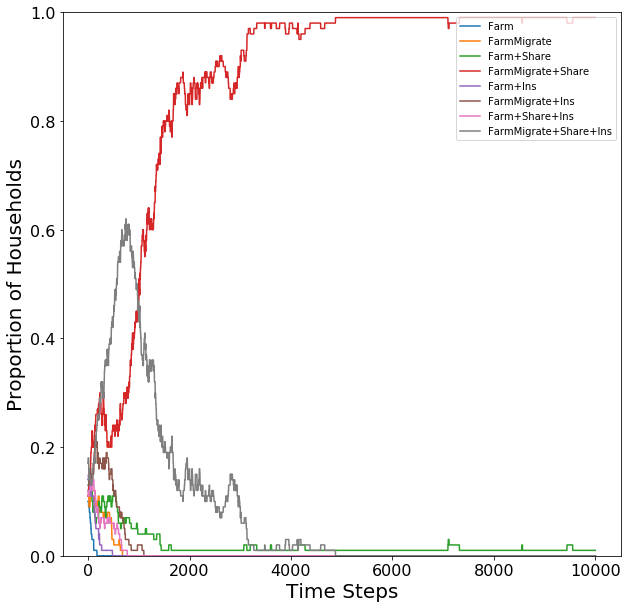

In [91]:
#Plot of strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}

for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros(time)


for t in range(time):
    for var_name, item in zip(local_variables.keys(), strategy_names):      
        local_variables[var_name][t] = sim_frequency_dist[0][t][item]

f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in local_variables.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend(loc = 'upper right')
ax1.set_ylim([0,1])
#ax1.set_xlim([0, 10])
ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('ExampleSelf-Interested.eps', bbox_inches='tight')


## Average of Multiple Simulations over Time

In [170]:
#Plot of average strategy distribution over time (averaged across simulations)

#simulation_run = np.load('Self-Interested_frequencydist.npy', allow_pickle = True)
simulation_run = sens_frequency_dist

local_variables = {key: [] for key in strategy_names}

avg_sim_time_distribution = {key: [] for key in strategy_names}

for var_name in strategy_names:
    
    local_variables[var_name] = np.zeros((simulations, time))
    for a in range(simulations):
        for t in range(time):
            local_variables[var_name][a,t] = simulation_run[-1][a][t][var_name]
    
    avg_time_distribution = np.zeros(time)
    for t in range(time):
        avg_time_distribution[t] = np.average(local_variables[var_name][:,t])
    
    avg_sim_time_distribution[var_name] = avg_time_distribution

f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0, time, time)

for key in strategy_names:
    y = np.asarray(avg_sim_time_distribution[key])
    #err = np.asarray(std_final_proportion[key])
    ax.plot(x, y, label = str(key))
    #ax.fill_between(x, y - err, y + err)

    ax.set_ylim([0,1])
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Average Strategy Distribution', fontsize=20)

plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=18)
#plt.show()

plt.savefig('Self-Interested_frequencydist.png', bbox_inches='tight')

## Single-Parameter Sensitivity

In [ ]:
#Create arrays for proportion of households in any strategy over time
parameter_array = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

sens_frequency_dist = {}
avg_proportion = {key: [] for key in strategy_names}
std_proportion = {key: [] for key in strategy_names}

avg_final_proportion = {key: [] for key in strategy_names}
std_final_proportion = {key: [] for key in strategy_names}


for value in parameter_array:
    key = str(value)
    sens_frequency_dist[key] = np.load('Self-Interested_DroughtSens' + str(value) + '_frequencydist.npy', allow_pickle=True)
    print(len(sens_frequency_dist[key]))
    local_variables = {}
    avg_sim_proportion = {}
    final_sim_proportion = {}
    avg_time_proportion = {}

    for item in strategy_names:
        var_name = str(item)
        local_variables[var_name] = np.zeros((simulations,time))
        avg_sim_proportion[var_name] = np.zeros(simulations)
        final_sim_proportion[var_name] = np.zeros(simulations)
        avg_time_proportion[var_name] = np.zeros(time)

    for a in range(simulations):
        for t in range(time):
            for var_name, item in zip(local_variables.keys(), strategy_names):      
                local_variables[var_name][a,t] = sens_frequency_dist[value][-1][a][t][item]

    for var_name in local_variables.keys():
        
        for sim in range(simulations):
            avg_sim_proportion[var_name][sim] = np.average(local_variables[var_name][sim,:])
            final_sim_proportion[var_name][sim] = local_variables[var_name][sim,-1]
            
        avg_proportion[var_name].append(np.average(avg_sim_proportion[var_name]))
        avg_final_proportion[var_name].append(np.average(final_sim_proportion[var_name]))
        
        std_proportion[var_name].append(np.std(avg_sim_proportion[var_name]))
        std_final_proportion[var_name].append(np.std(final_sim_proportion[var_name]))


In [ ]:
#Line Plot of Avg Strategy Proportions as a function of parameter

f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0.0, 1.0, 6)

for key in strategy_names:
    y = np.asarray(avg_proportion[key])
    err = np.asarray(std_proportion[key])
    ax.plot(x, y, label = str(key))
    #ax.fill_between(x, y - err, y + err)

    ax.set_ylim([0,1])
ax.set_xlabel('Moralis $k$ factor')
ax.set_ylabel('Avg Strategy Share')
plt.legend()
plt.show()

#plt.savefig('Altruistic_AltruismSens.png', bbox_inches='tight')

## Bar Graph of Final Strategy Proportions

In [ ]:
#Bar Graph of average strategy distributions over simulations

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_time_proportion = {}
avg_proportion={}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])



f, ax = plt.subplots(figsize=[10,10])
x = np.arange(time)

categories = np.arange(1)
ax.bar(categories, avg_proportion['FarmMigrate'], label='FarmMigrate', color='orange')
ax.bar(categories, avg_proportion['FarmMigrate+Share'], bottom=avg_proportion['FarmMigrate'], label='FarmMigrate+Share', color='red')
ax.bar(categories, avg_proportion['FarmMigrate+Ins'], bottom=(avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Ins', color='sienna')
ax.bar(categories, avg_proportion['FarmMigrate+Share+Ins'], bottom=(avg_proportion['FarmMigrate+Ins'] + avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Share+Ins', color='black')

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()

#ax1.set_xlabel('Time Steps', size=20)
ax.set_ylabel('Proportion of Time Spent in Each Strategy', size=20)

plt.yticks(fontsize=16)
plt.show()

#np.save(avg_proportion, 'P0.3_proportion_10sim.npy')

#print(type(avg_proportion))
#data = json.dumps(avg_proportion)
#f = open("P0.01_proportion.json","w")
#f.write(data)
#f.close()

#plt.savefig('Altruism05_10sim.eps', bbox_inches='tight')

# Transition Matrix Calculations

In [113]:
#strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
strategy_names = ['Farm', 'Farm+Ins', 'Farm+Share', 'Farm+Share+Ins', 'FarmMigrate', 'FarmMigrate+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
mu_farm_drought, mu_farm_nd, var_farm_d, var_farm_nd = farm_drought(mu_farm, farm_k, p_drought, objective_drought)
matrix = transition_matrix(strategy_names, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, mutation_rate)
print(matrix)

#transpose_matrix = np.transpose(matrix)

Avg non-drought income: 201.69601369093553
Current Strategy: Farm
Current Strategy: Farm+Ins
Current Strategy: Farm+Share
Current Strategy: Farm+Share+Ins
Current Strategy: FarmMigrate
Current Strategy: FarmMigrate+Ins
Current Strategy: FarmMigrate+Share
Current Strategy: FarmMigrate+Share+Ins
{'Farm': {'Farm': 0.6044881311790331, 'Farm+Ins': 0.0, 'Farm+Share': 3.2443819103207516e-212, 'Farm+Share+Ins': 0.0, 'FarmMigrate': 0.09801779956873621, 'FarmMigrate+Ins': 0.09920844896794166, 'FarmMigrate+Share': 0.0991328238464193, 'FarmMigrate+Share+Ins': 0.09915279643786971}, 'Farm+Ins': {'Farm': 0.0, 'Farm+Ins': 0.6044908155121758, 'Farm+Share': 3.54010415948405e-212, 'Farm+Share+Ins': 0.0, 'FarmMigrate': 0.09801679228883467, 'FarmMigrate+Ins': 0.09920791127442048, 'FarmMigrate+Share': 0.0991322493724412, 'FarmMigrate+Share+Ins': 0.09915223155212792}, 'Farm+Share': {'Farm': 0.0, 'Farm+Ins': 0.0, 'Farm+Share': 0.6001660912665459, 'Farm+Share+Ins': 0.0, 'FarmMigrate': 0.09999176870368226, 'Far

In [114]:
from scipy.linalg import eig
from array import array

a = []
for key in matrix:
    row = []
    for item in matrix[key]:
        row.append(matrix[key][item])
    a.append(row)
    
probability_matrix = np.array(a)
print('Matrix:', probability_matrix)

transpose_matrix = [[probability_matrix[j][i] for j in range(len(trans_matrix))] for i in range(len(trans_matrix[0]))]
print('Transpose:', transpose_matrix)

A=np.append(np.transpose(probability_matrix)-np.identity(8),[[1,1,1,1,1,1,1,1]],axis=0) 
b=np.transpose(np.array([0,0,0,0,0,0,0,0,1]))
eigen = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

total = np.sum(eigen)
stationary_dist = []
for value in eigen:
    stationary_dist.append(np.abs(value)/ total)
    
stationary_dist

#w,v = scipy.linalg.eig(probability_matrix, left=True, right=False)

#print('E-value:', w)
#print('E-vector', v)
#idx = np.argmin(np.abs(w - 1))
#vec = np.real(v[idx])

#print('Stationary Distribution:', vec/np.sum(vec))

#for value, vector in zip(w,v):
    #if value == 1:
    #if np.min(vector) > -0.01:
        #stationary_dist = []
        #total = np.sum(np.abs(vector))
        #for value in vector:
            #stationary_dist.append(np.abs(value) / total)
        #print('Possible distribution:', stationary_dist)

Matrix: [[6.04488131e-001 0.00000000e+000 3.24438191e-212 0.00000000e+000
  9.80177996e-002 9.92084490e-002 9.91328238e-002 9.91527964e-002]
 [0.00000000e+000 6.04490816e-001 3.54010416e-212 0.00000000e+000
  9.80167923e-002 9.92079113e-002 9.91322494e-002 9.91522316e-002]
 [0.00000000e+000 0.00000000e+000 6.00166091e-001 0.00000000e+000
  9.99917687e-002 9.99994438e-002 9.98678103e-002 9.99748859e-002]
 [0.00000000e+000 0.00000000e+000 1.16155143e-204 6.07808930e-001
  9.89519844e-002 9.96615441e-002 9.69950219e-002 9.65825197e-002]
 [1.10211175e-217 1.01010734e-217 5.93082861e-079 4.62602118e-179
  8.27510166e-001 5.79470530e-002 5.71722611e-002 5.73705199e-002]
 [2.97173066e-166 2.78190376e-166 3.34485479e-061 5.24251571e-137
  4.39604191e-002 8.57087039e-001 4.93995934e-002 4.95529481e-002]
 [3.35208391e-170 3.13286787e-170 3.51025103e-002 8.69471803e-045
  4.44199832e-002 5.06151803e-002 8.21345512e-001 4.85168142e-002]
 [3.56493423e-169 3.33320634e-169 3.77443815e-002 1.97482884e

[5.478091300659491e-17,
 8.306098673178029e-17,
 0.04213025737582437,
 4.001071468014586e-16,
 0.21486000523817464,
 0.28024190494876156,
 0.23535595673910703,
 0.22741187569813207]

# Calculate Utilities as a Function of Strategy Share

In [186]:
#Calculate income distribution properties

mu_farm_drought, mu_farm_nd, var_farm_d, var_farm_nd = farm_drought(mu_farm, farm_k, p_drought, objective_drought)

print(mu_farm_drought)
print(mu_farm_nd)
print(var_farm_d)
print(var_farm_nd)

Avg non-drought income: 201.88736007088187
9.702835752833877
201.88736007088187
23667.75305960538
45971.51518636118


In [192]:
#Calculate utility of strategy x as a function of share of population playing strategy

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
x = np.arange(0,households,1)

target_strategy = ['FarmMigrate+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']

colors = ['brown', 'red', 'gray']
y = {key: np.zeros(len(x)) for key in target_strategy}

alternate_strategy = 'FarmMigrate+Share'

for strategy in target_strategy:
    for i in range(households):
        distribution = {key: 0 for key in strategy_names}
        
        distribution[strategy] = i / households
        
        if strategy == alternate_strategy:
            distribution[strategy] = households / households
        else:
            distribution[alternate_strategy] = (households - i) / households
        
        utility = utility_select(utility_function, strategy_names, risk_factor, distribution, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
        
        if utility_function == 'Altruistic':
            y[strategy][i] = utility[alternate_strategy][strategy]
        else:
            y[strategy][i] = utility[strategy]

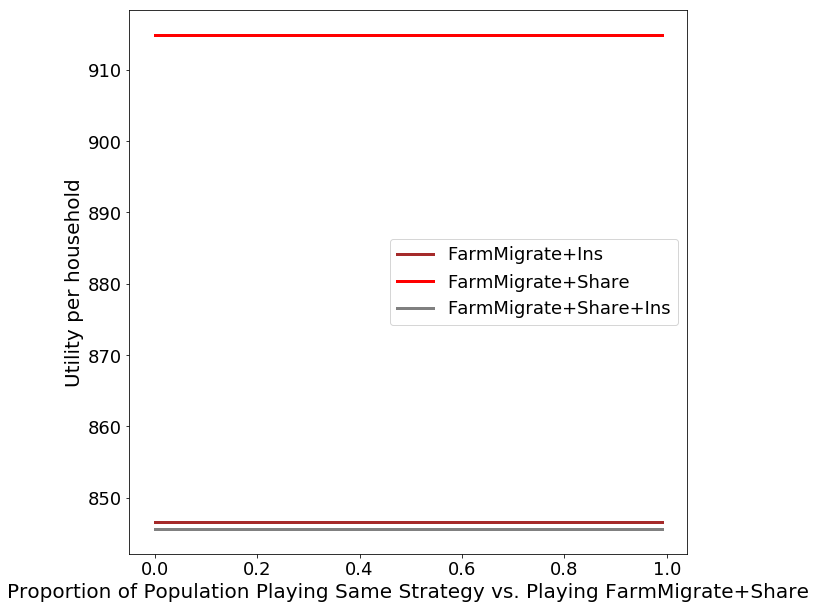

In [193]:
#Plot results

f, ax1 = plt.subplots(figsize=[10,10])

for item, c in zip(target_strategy, colors):
    ax1.plot(x / households, y[item], label=str(item), color=c, lw=3)

ax1.set_xlabel('Proportion of Population Playing Same Strategy vs. Playing ' + str(alternate_strategy), size=20)
ax1.set_ylabel('Utility per household', size = 20)

#ax1.set_ylim([900,1100])
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

#plt.savefig(str(utility_function) + '_Utilities_' + str(alternate_strategy) + '.png', bbox_inches='tight')

# Plot Fermi Probabilities as a Function of Relative Utility Difference

In [93]:
#Calculate transition probability of switching from strategy x to y as a function of relative utility differences

def fermi_prob(rel_utility_gap, sel_strength):
        
    #Probability will be lower value (closer to 0) when selection strength and utility difference is high
    try:
        transition_probability = (1 + math.exp(sel_strength * (-rel_utility_gap))) ** (-1)
    except OverflowError:
        transition_probability = 0
    
    return transition_probability

In [109]:
#Generate Plot of probability vs. utility gap
sel_strength = [1, 5, 10, 50, 100]
utility_gaps = np.linspace(-1, 1, 50)
trans_prob = np.zeros((len(sel_strength), len(utility_gaps)))

for j, value in enumerate(sel_strength):
    for i in range(len(utility_gaps)):
        trans_prob[j, i] = fermi_prob(utility_gaps[i], value)
    

f, ax1 = plt.subplots(figsize=[10,10])

for k, item in enumerate(sel_strength):
    ax1.plot(utility_gaps, trans_prob[k], label = '$Beta = $' + str(item))
    
ax1.set_xlabel('Relative Utility Difference from B to A')
ax1.set_ylabel('Probability of Transition from A to B')
ax1.set_xlim([-0.5, 0.5])

plt.legend()
#plt.show()

plt.savefig('Logisticfunction_Betasens.png', bbox_inches='tight')

In [18]:
#Plot of average strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_proportion = {}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])
    
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in avg_proportion.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()
ax1.set_ylim([0,1])
ax1.set_xlim([0, time])

ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('Altruism05.eps', bbox_inches='tight')


NameError: name 'avg_time_proportion' is not defined

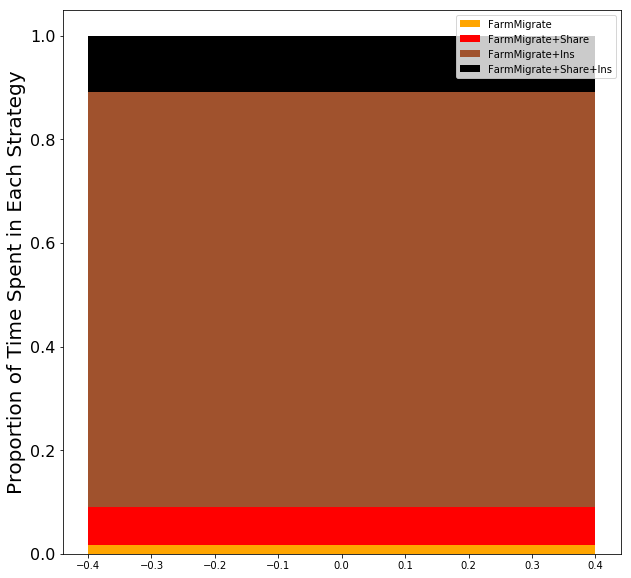

In [11]:
# Create Bar plot with separate bars for each drought probability tested

probabilities = [0.01, 0.05, 0.1, 0.3]
local_variables = {}
means = {'FarmMigrate':[], 'FarmMigrate+Share':[], 'FarmMigrate+Ins':[], 'FarmMigrate+Share+Ins':[]}



for item in probabilities:
    
    f = open('P' + str(item) + '_proportion.json',)
    var_name = ('p_' + str(item))
    local_variables[var_name] = json.load(f)
    f.close()


categories = means.keys()

for strategy in categories:
    for key,value in local_variables.items():
        means[strategy].append(local_variables[key][strategy])

probability_order = list(local_variables.keys())

f, ax = plt.subplots(figsize=[10,10])

bottom_1 = means['FarmMigrate']
bottom_2 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] for i in range(len(means['FarmMigrate']))]
bottom_3 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] + means['FarmMigrate+Ins'][i] for i in range(len(means['FarmMigrate']))]

#[test_list1[i] + test_list2[i] for i in range(len(test_list1))]
ax.bar(probability_order, means['FarmMigrate'], label = 'FarmMigrate', color='dodgerblue')
ax.bar(probability_order, means['FarmMigrate+Share'], bottom = bottom_1, label = 'FarmMigrate+Share', color='green')
ax.bar(probability_order, means['FarmMigrate+Ins'], bottom = bottom_2, label = 'FarmMigrate+Ins', color='salmon')
ax.bar(probability_order, means['FarmMigrate+Share+Ins'], bottom = bottom_3, label = 'FarmMigrate+Share+Ins', color='darkorchid')

ax.set_xlabel('Drought Probability', size=18)
ax.set_ylabel('Proportion of Time', size=18)


plt.legend(fontsize=16)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


#plt.show()

plt.savefig('DroughtSensitivity.eps', bbox_inches='tight')